In [13]:
from fastai.vision.all import *
from facenet_pytorch import MTCNN

In [14]:
train_df = pd.read_csv('./Dataset/fairface_label_train.csv').drop(columns=['service_test'])
val_df = pd.read_csv('./Dataset/fairface_label_val.csv').drop(columns=['service_test']) 

In [15]:
mtcnn = MTCNN(
    image_size=224,
    margin=20,
    keep_all=True,
    post_process=True,
    select_largest=False,
    thresholds=[0.6, 0.7, 0.7]  
)

def detect_face_mtcnn(image_path):
    img = Image.open(image_path).convert('RGB')
    faces, _ = mtcnn.detect(img)
    
    if faces is None:
        return img 

    face_images = []
    for (x1, y1, x2, y2) in faces:
        face = img.crop((x1, y1, x2, y2))
        face_images.append(face)
    
    return face_images[0] if face_images else img

def get_face_image(row):
    image_path = './Dataset/' + row['file']
    return detect_face_mtcnn(image_path)

In [16]:
fairface_block = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),  
    get_x=get_face_image,                       
    get_y=ColReader(['age', 'gender', 'race']), 
    splitter=RandomSplitter(seed=42),           
    item_tfms=Resize(224),                      
    batch_tfms=[
        Normalize.from_stats(*imagenet_stats),
        *aug_transforms(
            size=224,
            max_rotate=10,
            min_scale=0.75,
            flip_vert=True,
            max_lighting=0.1,
            max_warp=0.0,
            p_affine=0.75,
            p_lighting=0.75
        )
            
    ] 
)

dls = fairface_block.dataloaders(train_df, bs=64)

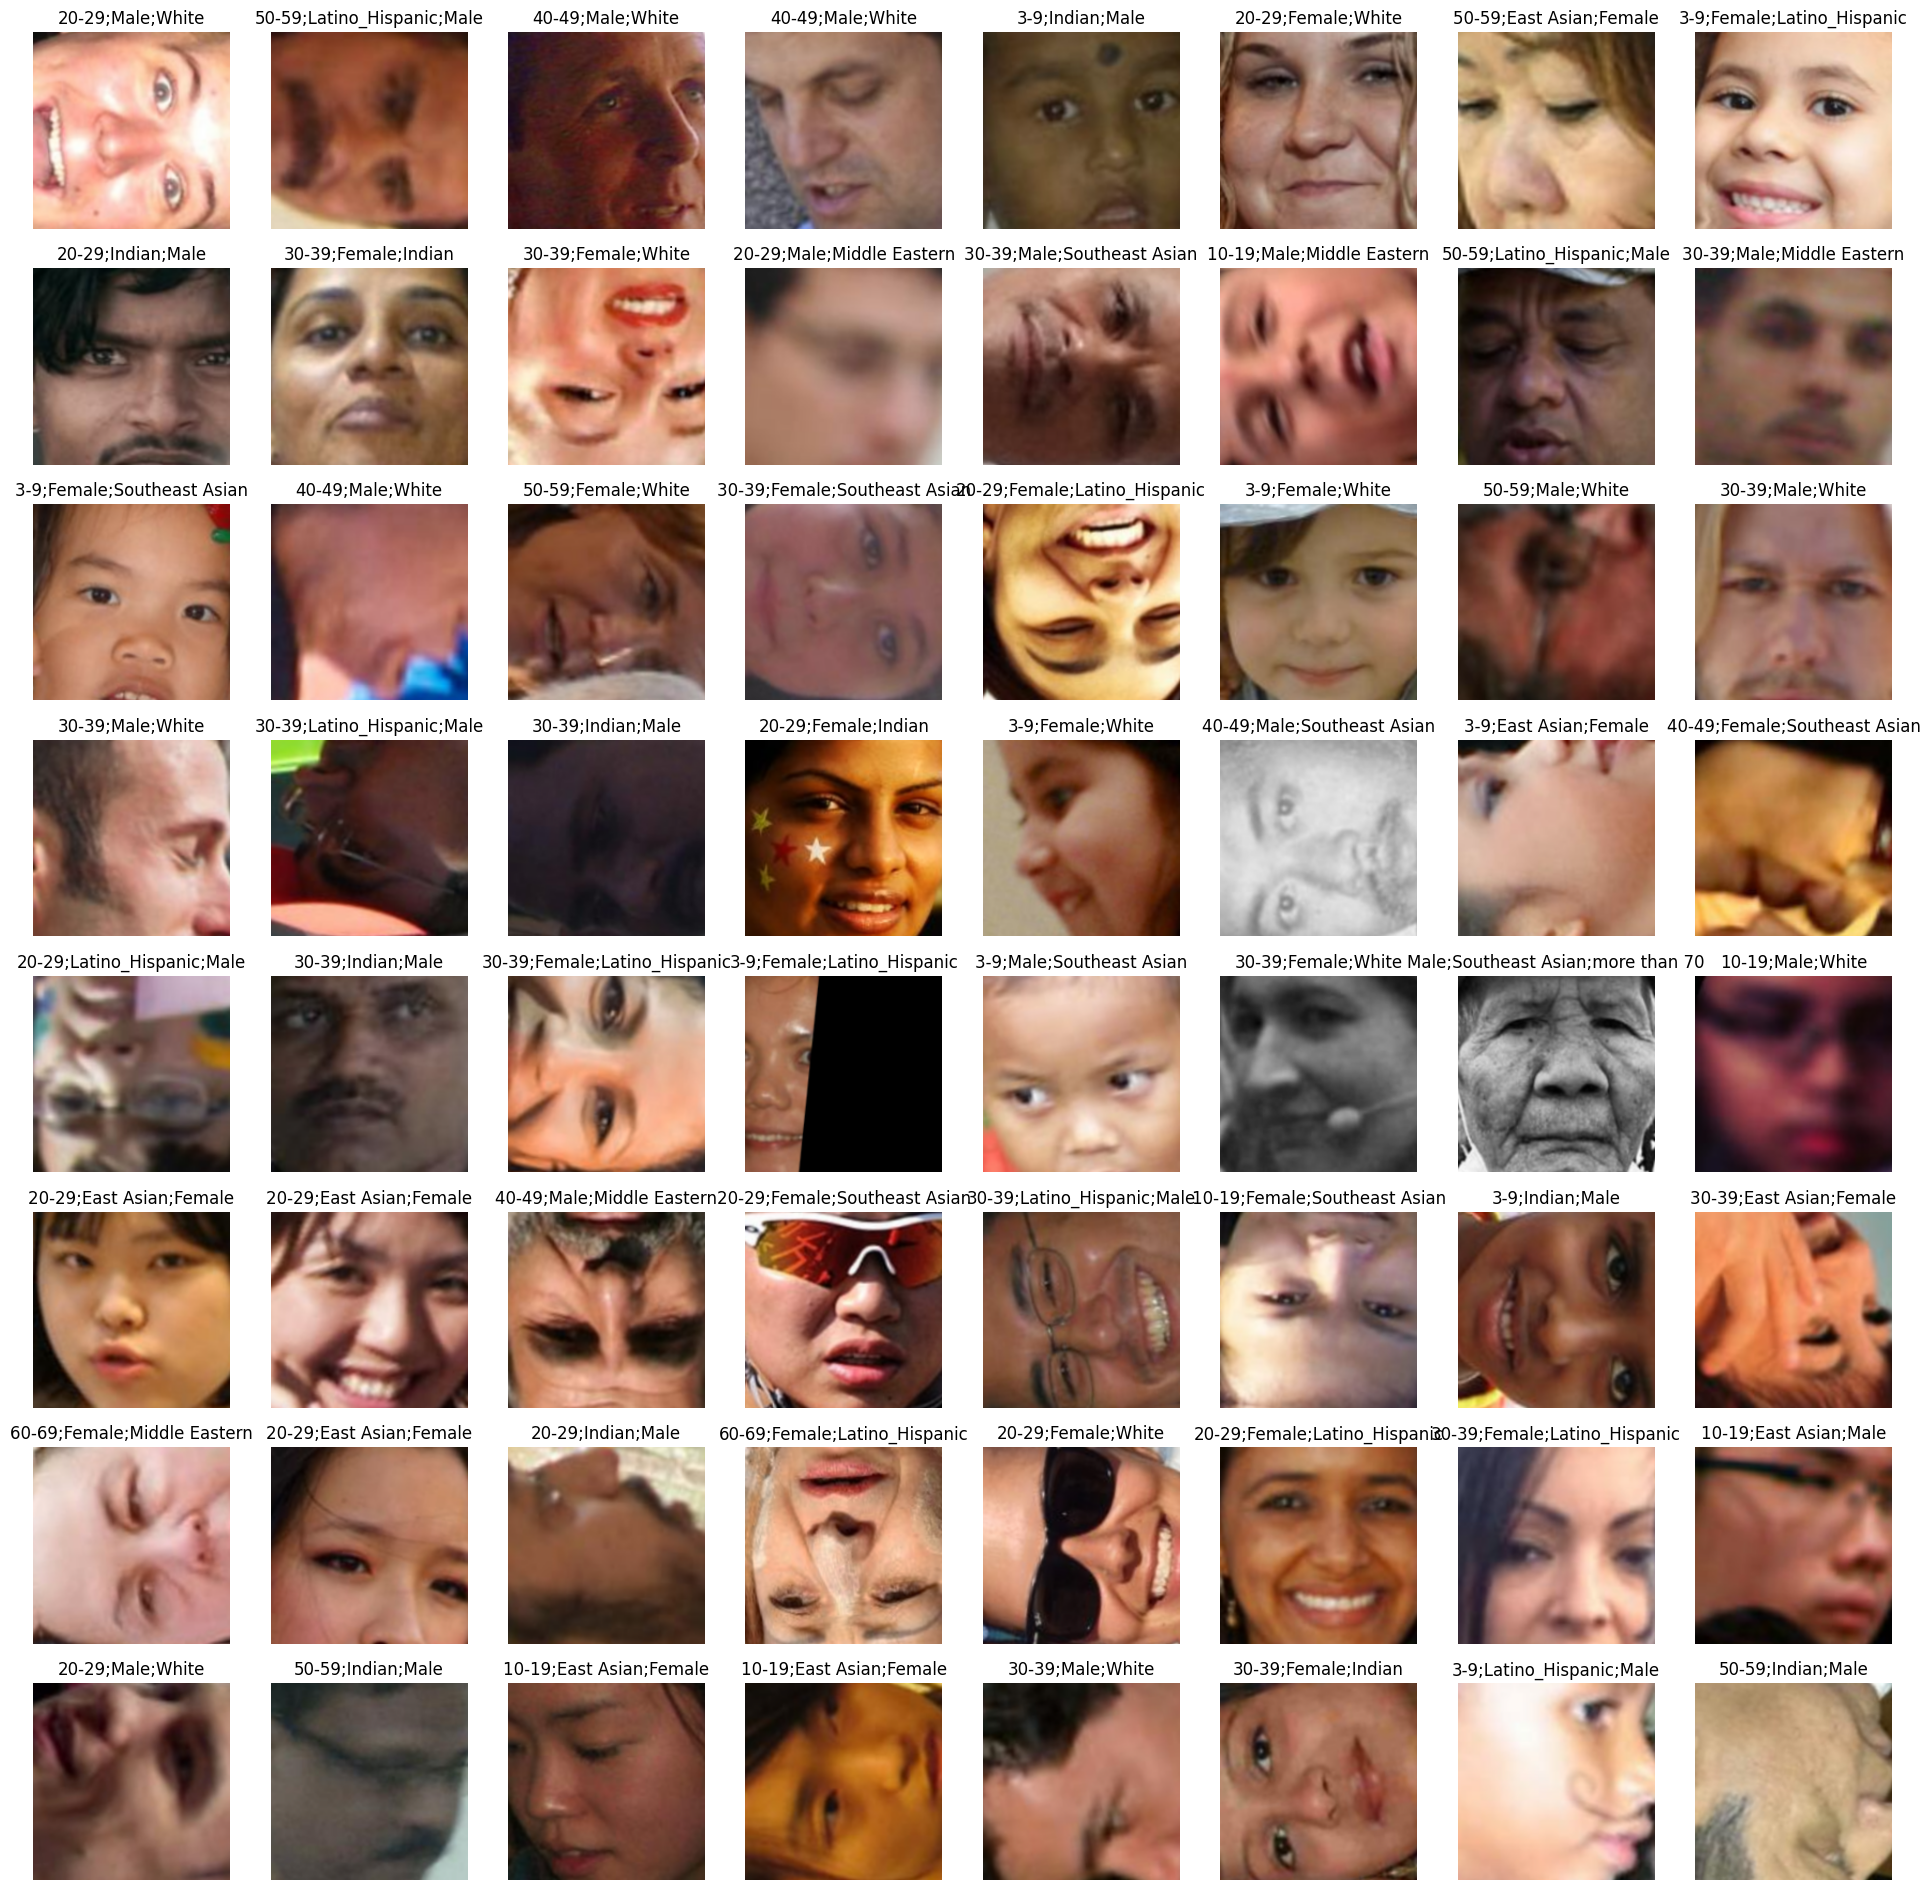

In [17]:
dls.show_batch(
    max_n=116
)

In [18]:
import os
from tqdm import tqdm

train_faces_path = './Dataset/face_train/'
val_faces_path = './Dataset/face_val/'

def save_cropped_faces(df, dataset_path, output_path):
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_path = os.path.join(dataset_path, row['file'])
        
        if not os.path.exists(image_path):
            print(f"File {image_path} does not exist. Skipping.")
            continue
        
        try:
            img_face = detect_face_mtcnn(image_path)
            
            if img_face:
                output_file = os.path.join(output_path, os.path.basename(row['file']))
                img_face.save(output_file)
        except Exception as e:
            print(f"Failed to process {image_path}: {e}")

save_cropped_faces(train_df, './Dataset/', train_faces_path)
save_cropped_faces(val_df, './Dataset/', val_faces_path)